In [1]:
import pennylane as qml
import pennylane.numpy as np
import jax.numpy as jnp
from scipy.special import legendre
import jax
import optax

from time import time
import pickle

import matplotlib.pyplot as plt


import os, sys, argparse

parent = os.path.abspath('../src')
sys.path.insert(1, parent)

from perceptron import Perceptron



# Set to float64 precision and remove jax CPU/GPU warning
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")


In [2]:

def get_loss_function(perceptron, ts, H_obj, dev):

    @jax.jit
    @qml.qnode(dev, interface="jax")
    def loss(param_vector):

        # hamitlonian_params = dictionary_to_hamiltonian_parameters(params_dict)

        param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

        qml.evolve(perceptron.H)(param_list, ts)

        return qml.expval(H_obj)

    return loss


In [3]:

# setting up the problem
perceptron_qubits = 8
pulse_basis = 10
ts = jnp.array([0.0, 1.0])

dev = qml.device("default.qubit.jax", wires = perceptron_qubits)


perceptron = Perceptron(perceptron_qubits, pulse_basis, basis='gaussian', pulse_width=0.5e-2)

H =  perceptron.H

H_obj, H_obj_spectrum = perceptron.get_1d_ising_hamiltonian(0.1)

e_ground_state_exact = H_obj_spectrum[0]

print(f'Ising Model Hamiltonian:\nH = {H_obj}')
print(f'Exact ground state energy: {e_ground_state_exact}')
    



I0000 00:00:1696453031.110863       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
/Users/jorgegarciaponce/Research/Yelin/PerceptronLossLandscapes/.venv/lib/python3.11/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


Ising Model Hamiltonian:
H =   (0.1) [X0]
+ (0.1) [X1]
+ (0.1) [X2]
+ (0.1) [X3]
+ (0.1) [X4]
+ (0.1) [X5]
+ (0.1) [X6]
+ (0.1) [X7]
+ (1.0) [Z0 Z1]
+ (1.0) [Z1 Z2]
+ (1.0) [Z2 Z3]
+ (1.0) [Z3 Z4]
+ (1.0) [Z4 Z5]
+ (1.0) [Z5 Z6]
+ (1.0) [Z6 Z7]
Exact ground state energy: -7.025018814832985


In [4]:
# getting the loss_function
loss = get_loss_function(perceptron, ts, H_obj, dev)

param_vector = perceptron.get_random_parameter_vector(0)

print(f'Initial parameters: {param_vector}')

print(f'Initial loss: {loss(param_vector)}')

initial_gradients = jax.grad(loss)(param_vector)
print(f'Initial gradients: {initial_gradients}')

value_and_grad = jax.jit(jax.value_and_grad(loss))

Initial parameters: [8.96178501e-01 9.49218617e-01 2.46217090e-01 7.77260625e-01
 4.21847324e-01 4.46158200e-01 1.88113537e-01 4.90409831e-01
 9.47344597e-01 3.15252023e-01 3.62207289e-01 2.53809554e-01
 3.93008128e-01 9.95297207e-01 1.38133822e-01 3.14428203e-01
 9.03045321e-01 8.49992586e-04 7.52386288e-01 4.64430762e-01
 5.86370441e-01 2.50964444e-01 3.00912751e-01 8.84352472e-01
 7.77673780e-01 8.92828384e-01 9.96348935e-01 8.27666530e-01
 7.25106759e-01 7.19690589e-02 4.15099800e-01 7.06884267e-01
 5.90742152e-01 1.00899317e-01 5.07947830e-01 9.04033824e-01
 6.72729528e-01 2.91984936e-01 8.90622258e-01 1.98596231e-01
 3.12725679e-01 8.72778520e-01 9.67400091e-01 5.51698599e-01
 8.29694814e-01 5.83575516e-02 4.52753152e-01 1.95357080e-01
 2.03813150e-01 2.25559403e-01 7.87141194e-02 7.06892405e-01
 5.22134123e-01 8.53968834e-01 1.86912165e-01 8.93409607e-01
 5.05277314e-01 3.12063807e-01 4.42955912e-01 2.60315845e-01
 9.70165513e-01 4.81873320e-01 3.73939261e-02 5.90524048e-01
 7.9

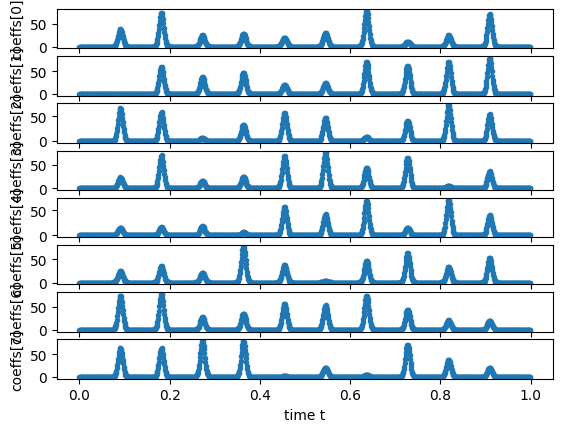

In [5]:
ts = jnp.linspace(0.0, 1, 1000)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, sharex=True)
for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-")
    ax.set_ylabel(f"coeffs[{i}]")
ax.set_xlabel("time t")
plt.show()


In [6]:

from datetime import datetime

n_epochs = 100
param_vector = perceptron.get_random_parameter_vector(32987)

# The following block creates a constant schedule of the learning rate
# that increases from 0.1 to 0.5 after 10 epochs
# schedule0 = optax.constant_schedule(1e-1)
# schedule1 = optax.constant_schedule(5e-1)
# schedule = optax.join_schedules([schedule0, schedule1], [20])
# optimizer = optax.adam(learning_rate=schedule)
optimizer = optax.adam(learning_rate=0.25)
opt_state = optimizer.init(param_vector)

energy = np.zeros(n_epochs + 1)
energy[0] = loss(param_vector)
mean_gradients = np.zeros(n_epochs)
param_trajectory = []

## Compile the evaluation and gradient function and report compilation time
time0 = datetime.now()
_ = value_and_grad(param_vector)
time1 = datetime.now()
print(f"grad and val compilation time: {time1 - time0}")


## Optimization loop
for n in range(n_epochs):
    val, grads = value_and_grad(param_vector)
    updates, opt_state = optimizer.update(grads, opt_state)
    param_vector = optax.apply_updates(param_vector, updates)

    mean_gradients[n] = np.mean(np.abs(grads))
    energy[n+1] = val

    # print(f"            param: {param_vector}")

    if not n % 10:
        print(f"{n+1} / {n_epochs}; energy discrepancy: {val-e_ground_state_exact}")
        print(f"mean grad: {mean_gradients[n]}")



print(f"Found ground state: {energy[-1]}")


grad and val compilation time: 0:00:39.508076
1 / 100; energy discrepancy: 6.7611423284367556
mean grad: 0.46312542026550185
11 / 100; energy discrepancy: 5.065466386331158
mean grad: 0.38790573546234003
21 / 100; energy discrepancy: 2.9709247336816977
mean grad: 0.392882728187466
31 / 100; energy discrepancy: 2.721316701291986
mean grad: 0.37601502035489404
41 / 100; energy discrepancy: 2.4602532627517695
mean grad: 0.2932648397081168
51 / 100; energy discrepancy: 3.984111694401952
mean grad: 0.39989766477960786
61 / 100; energy discrepancy: 2.4753955760727067
mean grad: 0.24588467770560554
71 / 100; energy discrepancy: 2.182127758428962
mean grad: 0.15912595191496784
81 / 100; energy discrepancy: 2.0106801616407557
mean grad: 0.0784496309645573
91 / 100; energy discrepancy: 1.9301524748299164
mean grad: 0.04800851677199281
Found ground state: -5.114807958560662


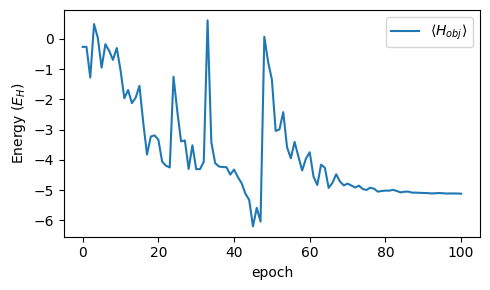

In [7]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

y = energy 
ax.plot(y, label="$\\langle H_{{obj}}\\rangle$")
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle$")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
# ax.set_yscale("log")
ax.set_ylabel("Energy ($E_H$)")
ax.set_xlabel("epoch")
ax.legend()

plt.tight_layout()
plt.show()

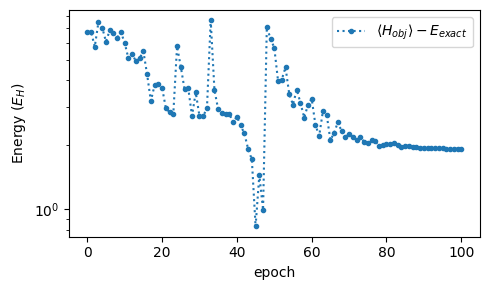

In [8]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

y = energy - e_ground_state_exact
ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Energy ($E_H$)")
ax.set_xlabel("epoch")
ax.legend()

plt.tight_layout()
plt.show()

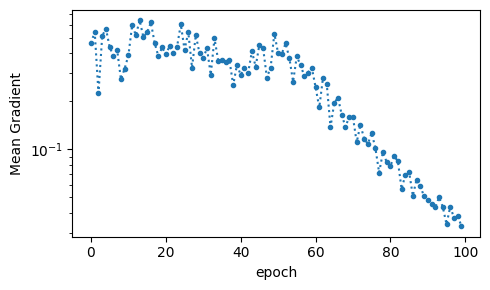

In [9]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = mean_gradients
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Mean Gradient")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

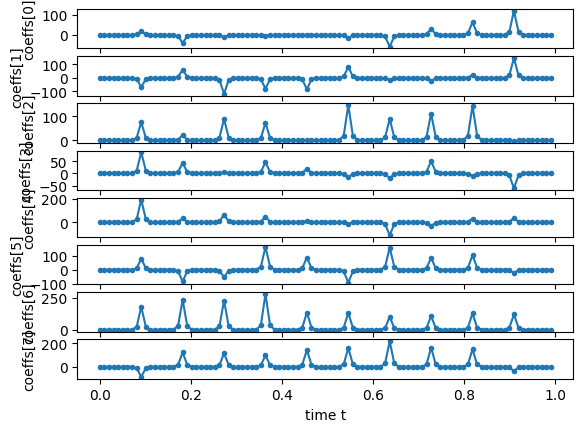

In [10]:
ts = jnp.linspace(0.0, 1, 100)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, sharex=True)
for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-")
    ax.set_ylabel(f"coeffs[{i}]")
ax.set_xlabel("time t")
plt.show()

In [11]:
# Calculating the Final Hessian

final_hessian = jax.jacrev(jax.jacrev(loss))(param_vector)
final_hessian_eigenvalues = jnp.linalg.eigvals(final_hessian)
final_hessian_eigenvalues

Array([ 5.44172273e+01+0.j,  5.55055969e+01+0.j,  4.48776978e+01+0.j,
        2.88479395e+01+0.j,  2.63058199e+01+0.j,  2.39691692e+01+0.j,
        2.19673794e+01+0.j,  2.07863416e+01+0.j,  1.91113305e+01+0.j,
        1.83431664e+01+0.j,  1.73358737e+01+0.j,  1.78336229e+01+0.j,
        9.55377730e+00+0.j,  8.05324022e+00+0.j,  2.82072150e+00+0.j,
        1.37245077e+00+0.j,  1.12219200e+00+0.j,  9.40742130e-01+0.j,
        6.49720607e-01+0.j,  5.83042600e-01+0.j,  4.34271292e-01+0.j,
        4.15704945e-01+0.j, -3.81458011e-01+0.j, -3.45441624e-01+0.j,
        3.50227276e-01+0.j, -2.54230112e-01+0.j,  2.65175002e-01+0.j,
        2.27545848e-01+0.j,  2.13494784e-01+0.j,  1.75407187e-01+0.j,
       -1.93488067e-01+0.j, -1.93001613e-01+0.j,  1.59654128e-01+0.j,
        1.43570248e-01+0.j,  1.39882279e-01+0.j,  1.33989165e-01+0.j,
        1.23221874e-01+0.j, -1.51967271e-01+0.j, -1.51374537e-01+0.j,
       -1.43750485e-01+0.j,  9.89887339e-02+0.j, -1.21845564e-01+0.j,
       -1.24918996e-

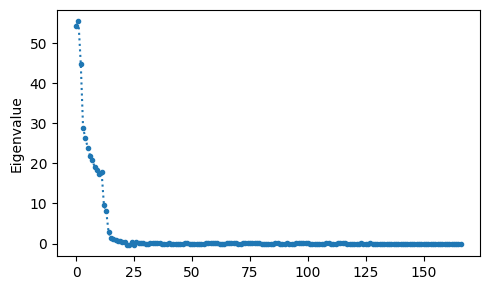

In [12]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = np.linalg.eigvals(final_hessian)

# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
# ax.set_yscale("log")
ax.set_ylabel("Eigenvalue")
# ax.set_xlabel("Eigenvalue")
# ax.legend()

plt.tight_layout()
plt.show()